## One Dimension Schrodinger Equation
### Finite Difference Method
https://physics.stackexchange.com/questions/258418/representing-hamiltonian-in-discrete-position-basis

For an arbitrary potential well,the Hamiltonian can be written as 
$$
H = - \frac{\hbar^{2}}{2m} \frac{\partial^{2}}{\partial x^{2}} + V(x) ,-\frac{L}{2}<x<\frac{L}{2}
$$ 
To find the solution $\psi_n(x)$ which satisfies $H \psi_n(x)=E_n \psi_n(x)$,where $n$ stands for the order of the eigenstate,we need to discretize the position basis.
By utilizing the difference form of 
$$
\frac{\partial^{2}\psi}{\partial x^{2}} \approx \frac{[\psi(x+h)-\psi(x)]-[\psi(x)-\psi(x-h)]}{h*h} = \frac{\psi(x+h)+\psi(x-h)-2\psi(x)}{h^{2}}
$$
Write $\psi_n(mh)$ as $\psi_{nm}$ and we can express the Hamiltonian in matrix form
$$
H_{nm} = -\frac{h^{2}}{2m}D_{nm} + V_{nm} 
$$
$$
D=\frac{1}{h^{2}}
\begin{pmatrix}
   -2&1&0&0&\cdots&0\\
   1&-2&1&0&\cdots&0\\
   0&1&-2&1&\cdots&0\\
   \vdots\\
   0&0&0&\cdots&1&-2\\
\end{pmatrix},\quad
V=\begin{pmatrix}
   V(0)&0&0&\cdots&0\\
   0&V(h)&0&\cdots&0\\
   0&0&V(2h)&\cdots&0\\
   \vdots&&&&0\\
   0&0&0&\cdots&V(Nh)\\
\end{pmatrix}
$$
Then the eigenvalue equation $H\psi_n=E_n\psi_n$ can be converted to $H_{nm}\psi_{nm}=E_n \psi_{nm}$,which can be solved by calculating the eigenvalues and eigenvectors

In [4]:
import numpy as np 
from scipy.linalg import eigh

#we set mu = hbar = 1

#mesh of the finite difference 
xmin = -1.5; xmax = 1.5; Nmesh = 2000
xmesh = np.linspace(xmin, xmax, Nmesh)
h = xmesh[1] - xmesh[0]

L = 1.0 # potential width 
V = 8.0 # potential depth 
def Vpot(x):
    if abs(x)< L/2.:
        return 3*x**4+0.5*x**3-3*x**2
    else:
        return 0.

According to the analysis, the finite difference Hamiltonian is

In [5]:
def buildH():
    Vx = np.array([Vpot(x) for x in xmesh]) # discretize potential function
    H = np.diag(Vx) 

    for i in range(Nmesh):
        H[i, i] += 1./(h*h)

    for i in range(Nmesh-1):
        H[i, i+1] += -0.5/(h*h)
        H[i+1, i] += -0.5/(h*h)
    # using diag
    
    return H 


Then we can solve the eigenvector and eigenvalue of the matrix $H$ 

energies: [0.42564627 2.11821573]


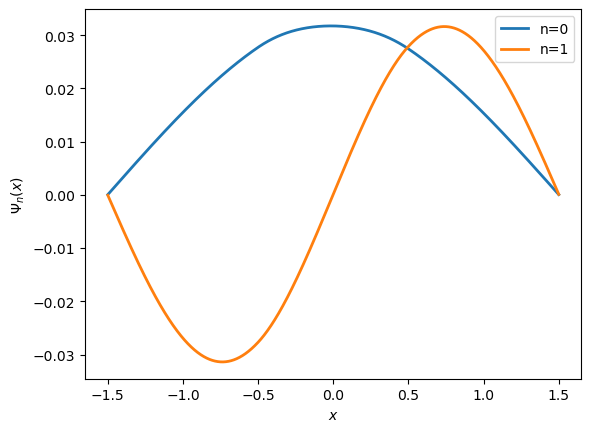

In [6]:
if __name__=='__main__':

    H = buildH()
    w, v = eigh(H) # w eighvalue, v eighvector
    norm = np.linalg.norm(v)
    
    nlowest = 2
    print ('energies:', w[0:nlowest])

    import matplotlib.pyplot as plt
    #plt.plot(xmesh, [Vpot(x) for x in xmesh], 'k-', lw=2)

    for n in range(nlowest):
        plt.plot(xmesh, v[:,n], label='n=%g'%(n), lw=2)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$\Psi_{n}(x)$')
    plt.legend()
    plt.show()

### A JAX Version
JAX.numpy is similar to numpy, but more powerful

In [7]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'notebook', 'no-latex'])

define a class to solve this problem, we can obtain $E_n,\psi_n(x),\rho_n(x),V(x)$

In [8]:
class Potential:
    def __init__(self, potential_func, 
                 mass = 1, hbar = 1,
                 xmin = -5, xmax = 5, ninterval = 1000):
        self.x = jnp.linspace(xmin, xmax, ninterval)
        self.U = jnp.diag(potential_func(self.x), 0)
        self.H = self.U + self.lap(ninterval) * (- hbar**2)/(2*mass)
        self.eigenval, self.eigenvec = self.eigensolve()
    
    def lap(self, N):
        """generate the second derivation matrix"""
        dx = self.x[1] - self.x[0]
        return (-2*jnp.diag(jnp.ones(N, jnp.float32), 0) + jnp.diag(jnp.ones(N - 1, jnp.float32), 1) + jnp.diag(jnp.ones(N - 1, jnp.float32), 1))/(dx**2)   # here we use jnp.diag
    
    def eigensolve(self):
        """solve the eigenvalue and eigenvector of matrix H"""
        w, v = jnp.linalg.eigh(self.H)
        idx_sorted = jnp.argsort(w)
        return w[idx_sorted], v[ :, idx_sorted]
    
    def wave_func(self, n = 0):
        return self.eigenvec[ :, n]
    
    def energy_level(self, n = 0):
        return self.eigenval[n]
    
    def plot_func(self, n = 1):
        leg = r'$E_{%s}=%.2f$'%(n, self.eigenval[n])
        plt.plot(self.x, self.eigenvec[:, n], label = leg)
        plt.xlabel(r"$x$")
        plt.ylabel(r'$\psi_{%s}(x)$'%(n))
        plt.legend(loc='best')
    
    def plot_density(self, n = 1):
        rho = self.eigenvec[:, n] * self.eigenvec[:, n]
        leg = r'$E_{%s}=%.2f$'%(n, self.eigenval[n])
        plt.plot(self.x, rho, label = leg)
        plt.xlabel(r"$x$")
        plt.ylabel(r'$\rho_{%s}(x)$'%(n))
        plt.legend(loc='best')
        
    def check(self,n = 1):
        hpsi = jnp.dot(self.H, self.eigenvec[:, n])
        epsi = self.eigenval[n] * self.eigenvec[:, n]
        plt.plot(self.x, hpsi, label = r'$H|\psi_{%s}\rangle$'%(n))
        plt.plot(self.x, epsi, label = r'$E_{%s}|\psi_{%s}\rangle$'%(n,n))
        plt.xlabel(r'$x$')
        plt.ylim(hpsi.min(),hpsi.max()*1.6)
        plt.legend(loc='best')
        
    def plt_potential(self):
        plt.plot(self.x, jnp.diag(self.U))
        plt.ylabel(r'potential')
        plt.xlabel(r'$x$')

#### Harmonic potential $V(x) = \frac{1}{2}m \omega^{2}x^{2}$



In [9]:
def harmonic(x,omega = 10):
    return 0.5*omega**2*x**2

In [10]:
schro_harmonic = Potential(harmonic)

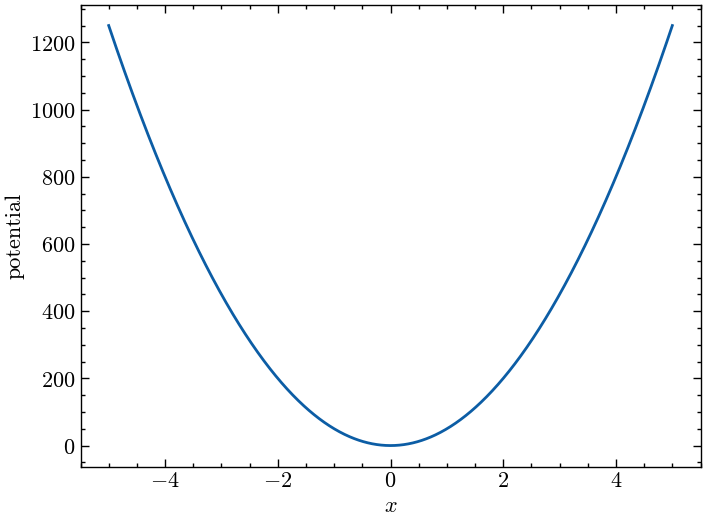

In [11]:
schro_harmonic.plt_potential()

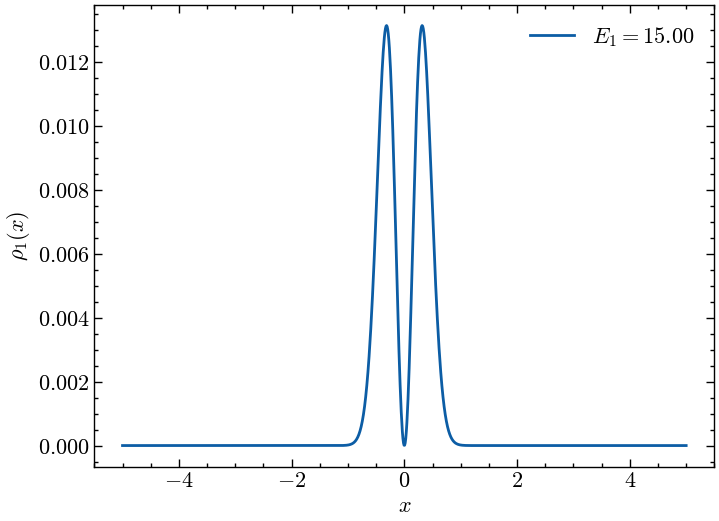

In [12]:
schro_harmonic.plot_density(1)

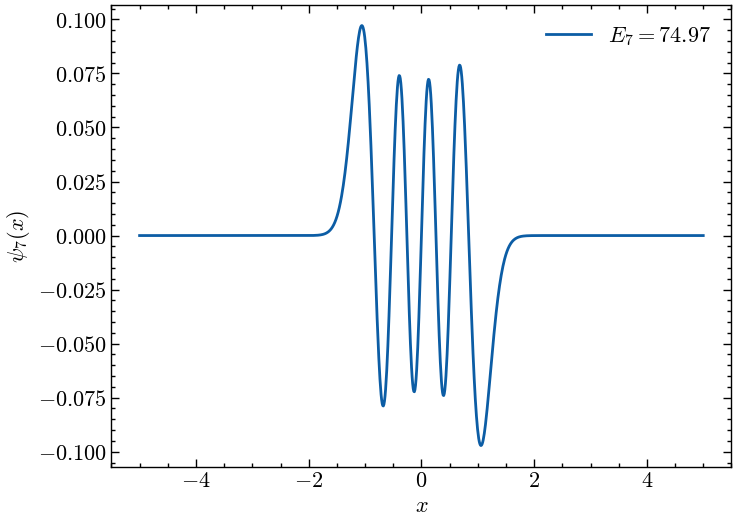

In [13]:
schro_harmonic.plot_func(7)

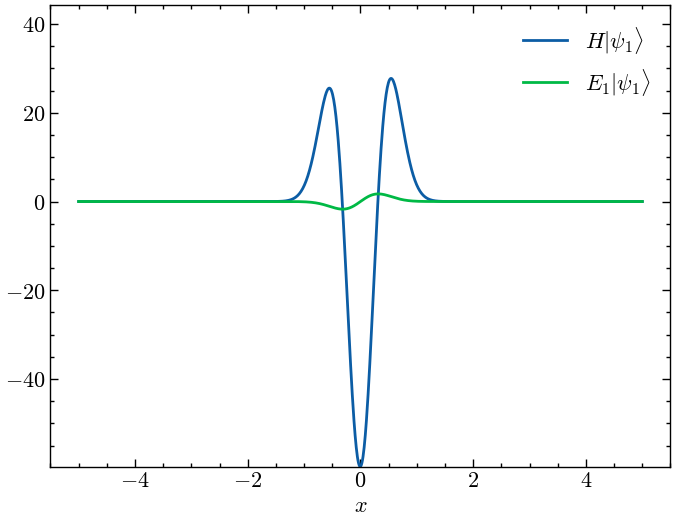

In [14]:
schro_harmonic.check(n=1)

#### infinite square potential well 

In [28]:
def infinite(x):
    if abs(x)

In [29]:
schro_inf = Potential(infinite)

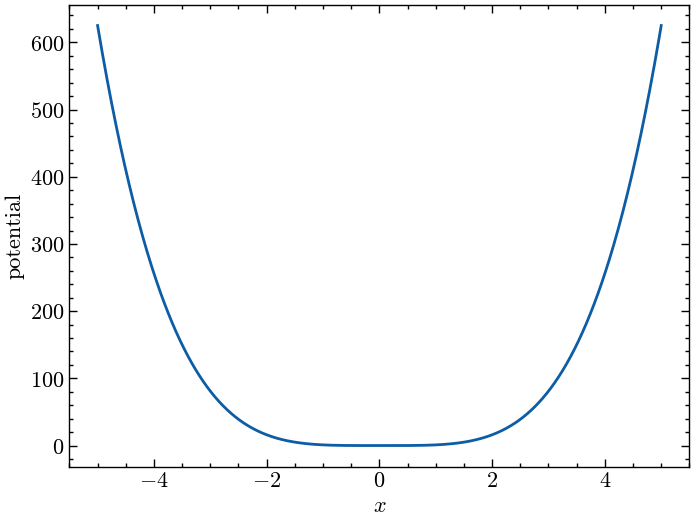

In [31]:
schro_inf.plt_potential()

## Varational Method